In [95]:
import pandas as pd
pd.set_option('display.max_columns', None)
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate
from transliterate import translit, get_available_language_codes
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import pickle 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from utils import estimate_power_importance
import seaborn as sns
from sklearn.utils.multiclass import type_of_target

In [94]:
data = pd.read_csv('../DATA/02_TEMP/X_train.csv', index_col=None)
target = pd.read_csv('../DATA/02_TEMP/Y_train.csv')['Температура']

# no labels on test data

# data_test = pd.read_csv('../DATA/02_TEMP/X_test.csv')
# target_test = pd.read_csv('../DATA/02_TEMP/Y_test.csv')

transliteration_mapping = {col: translit(col, 'ru', reversed=True) for col in data.columns}
transliteration_mapping_inverse = {val: key for key, val in transliteration_mapping.items()}
data.columns = transliteration_mapping_inverse.keys()
data = pd.get_dummies(data, columns=["Nomer zamera (stupen')"])

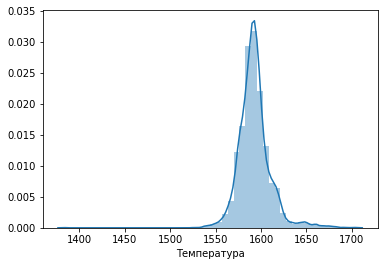

In [34]:
sns.distplot(target)

##### RF

In [41]:
cross_validate(estimator=RandomForestClassifier(n_estimators=100),
               X=data,
               y=target,
               cv=KFold(n_splits=5, shuffle=True),
               scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([10.48233485, 10.94343901, 10.37505794, 10.63004494, 10.65917706]),
 'score_time': array([0.35819006, 0.340065  , 0.33496308, 0.35418916, 0.33943486]),
 'test_r2': array([0.47412668, 0.60176915, 0.59461189, 0.64251951, 0.44872046]),
 'test_neg_mean_squared_error': array([-182.840143  , -115.2185904 , -126.06131834, -127.23658661,
        -173.1037302 ])}

In [105]:
cross_validate(estimator=RandomForestClassifier(n_estimators=100),
               X=data.drop(columns=['Temperatura']),
               y=target,
               cv=KFold(n_splits=5, shuffle=True),
               scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([9.71447587, 9.73086905, 9.70624399, 9.61965275, 9.73406792]),
 'score_time': array([0.34817934, 0.34236598, 0.34198999, 0.3386972 , 0.33797097]),
 'test_r2': array([0.29535503, 0.26532941, 0.13536183, 0.32171314, 0.34971019]),
 'test_neg_mean_squared_error': array([-223.54239019, -250.60163432, -263.91517629, -203.51354113,
        -229.48492591])}

###### GBDT

In [45]:
cross_validate(estimator=lgb.LGBMRegressor(),
               X=data,
               y=target,
               cv=KFold(n_splits=5, shuffle=True),
               scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([0.30298018, 0.36102509, 0.36068606, 0.34714794, 0.37538791]),
 'score_time': array([0.02851987, 0.03638077, 0.03568196, 0.03041887, 0.04801083]),
 'test_r2': array([0.78852556, 0.74467409, 0.69702182, 0.79828626, 0.74201477]),
 'test_neg_mean_squared_error': array([-68.90686916, -80.15271508, -96.76773791, -64.63898832,
        -87.16754606])}

In [106]:
cross_validate(estimator=lgb.LGBMRegressor(),
               X=data.drop(columns=['Temperatura']),
               y=target,
               cv=KFold(n_splits=5, shuffle=True),
               scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([0.29129004, 0.34397697, 0.35075402, 0.34291506, 0.35856986]),
 'score_time': array([0.03627992, 0.0357461 , 0.03656292, 0.03642607, 0.03706503]),
 'test_r2': array([0.48658517, 0.54536657, 0.54114917, 0.53331216, 0.50427757]),
 'test_neg_mean_squared_error': array([-160.02121889, -138.08984476, -169.05474413, -135.60059794,
        -169.82163875])}

In [46]:
reg_estimator_lgb = lgb.LGBMRegressor()

In [47]:
reg_estimator_lgb.fit(X=data, y=target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [87]:
multiclass_cols = []
binary_cols = []
cont_cols = []
other_cols = []

for col in data:
    if type_of_target(data[col]) == "multiclass":
        multiclass_cols.append(col)
    elif type_of_target(data[col]) == "binary":
        binary_cols.append(col)
    elif type_of_target(data[col]) == "continuous":
        cont_cols.append(col)
    else:
        print(type_of_target(data[col]), col)
        other_cols.append(col)

In [88]:
data[multiclass_cols]

,Nomer zamera (stupen'),Vremja s proshlogo nagreva,Vremja nagreva_summa_s_nachala,Vremja nagreva_summa_s_poslednego,Vremja nagreva_poslednee,Vremja nagreva_pervoe,Temperatura,Vremja s pervogo zamera,Vremja s proshlogo zamera
0,1,94.0,950.0,365.0,365.0,228.0,1571.0,575.0,575.0
1,2,34.0,1098.0,148.0,148.0,228.0,1571.0,773.0,198.0
2,3,84.0,1098.0,0.0,148.0,228.0,1571.0,823.0,50.0
3,4,122.0,1098.0,0.0,148.0,228.0,1571.0,861.0,38.0
4,1,89.0,137.0,0.0,137.0,137.0,1581.0,33.0,33.0
...,...,...,...,...,...,...,...,...,...
9782,2,115.0,516.0,260.0,127.0,256.0,1591.0,491.0,459.0
9783,3,229.0,709.0,193.0,193.0,256.0,1591.0,937.0,446.0
9784,4,307.0,750.0,41.0,41.0,256.0,1591.0,1302.0,365.0
9785,1,206.0,812.0,500.0,295.0,312.0,1569.0,839.0,839.0


In [89]:
data[binary_cols]

,Wire 1_isadded,Wire 2_isadded,Wire 3_isadded,Wire 4_isadded,Wire 5_isadded,Wire 6_isadded,Wire 7_isadded,Wire 8_isadded,Wire 9_isadded,Bulk 1_isadded,Bulk 2_isadded,Bulk 3_isadded,Bulk 4_isadded,Bulk 5_isadded,Bulk 6_isadded,Bulk 7_isadded,Bulk 8_isadded,Bulk 9_isadded,Bulk 10_isadded,Bulk 11_isadded,Bulk 12_isadded,Bulk 13_isadded,Bulk 14_isadded,Bulk 15_isadded
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
9783,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
9784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
9785,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [91]:
data[cont_cols]

,Aktivnaja moschnost'_summa_s_nachala,Reaktivnaja moschnost'_summa_s_nachala,Polnaja moschnost'_summa_s_nachala,Kolichestvo tepla_summa_s_nachala,Aktivnaja moschnost'_summa_s_poslednego,Reaktivnaja moschnost'_summa_s_poslednego,Polnaja moschnost'_summa_s_poslednego,Kolichestvo tepla_summa_s_poslednego,Aktivnaja moschnost'_srednee,Reaktivnaja moschnost'_srednee,Polnaja moschnost'_srednee,Vremja nagreva_srednee,Kolichestvo tepla_srednee,Aktivnaja moschnost'_poslednee,Reaktivnaja moschnost'_poslednee,Polnaja moschnost'_poslednee,Kolichestvo tepla_poslednee,Aktivnaja moschnost'_pervoe,Reaktivnaja moschnost'_pervoe,Polnaja moschnost'_pervoe,Kolichestvo tepla_pervoe,Wire 1_weight,Gaz 1,0,1,2,3,4,5,6,7
0,4.185392,2.768844,5.019156,1105.276547,1.659363,1.062669,1.970470,605.667332,1.046348,0.692211,1.254789,237.500000,276.319137,1.659363,1.062669,1.970470,605.667332,0.976059,0.687084,1.193639,222.541395,60.059998,29.749986,0.002886,1.053334,0.001848,0.007279,1.922220,0.004815,0.051739,0.104452
1,4.878147,3.183241,5.826395,1207.804249,0.692755,0.414397,0.807239,102.527702,0.975629,0.636648,1.165279,219.600000,241.560850,0.692755,0.414397,0.807239,102.527702,0.976059,0.687084,1.193639,222.541395,60.059998,29.749986,0.003499,0.517817,0.002093,0.006311,1.562489,0.004118,0.038486,0.077697
2,4.878147,3.183241,5.826395,1207.804249,0.000000,0.000000,0.000000,0.000000,0.975629,0.636648,1.165279,219.600000,241.560850,0.692755,0.414397,0.807239,102.527702,0.976059,0.687084,1.193639,222.541395,60.059998,29.749986,0.000000,0.000000,0.000000,0.005927,1.467563,0.003868,0.036148,0.072977
3,4.878147,3.183241,5.826395,1207.804249,0.000000,0.000000,0.000000,0.000000,0.975629,0.636648,1.165279,219.600000,241.560850,0.692755,0.414397,0.807239,102.527702,0.976059,0.687084,1.193639,222.541395,60.059998,29.749986,0.000000,0.000000,0.000000,0.005666,1.402792,0.003697,0.034553,0.069756
4,0.438063,0.283043,0.521549,60.014678,0.000000,0.000000,0.000000,0.000000,0.438063,0.283043,0.521549,137.000000,60.014678,0.438063,0.283043,0.521549,60.014678,0.438063,0.283043,0.521549,60.014678,0.000000,12.555561,0.000000,0.000000,0.000000,0.013275,1.818627,0.008577,0.380472,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9782,2.335864,1.635177,2.851498,450.258883,1.172969,0.802659,1.421319,152.557805,0.778621,0.545059,0.950499,172.000000,150.086294,0.574522,0.389889,0.694326,72.964311,1.162895,0.832519,1.430179,297.701077,118.110717,14.953657,0.002555,0.332370,0.001749,0.004757,0.917024,0.003330,0.030456,0.240551
9783,3.228512,2.239363,3.929394,622.539897,0.892648,0.604186,1.077896,172.281014,0.807128,0.559841,0.982349,177.250000,155.634974,0.892648,0.604186,1.077896,172.281014,1.162895,0.832519,1.430179,297.701077,118.110717,14.953657,0.002001,0.386280,0.001355,0.003446,0.664397,0.002390,0.015959,0.126052
9784,3.408725,2.355428,4.143749,629.928649,0.180213,0.116065,0.214355,7.388752,0.681745,0.471086,0.828750,150.000000,125.985730,0.180213,0.116065,0.214355,7.388752,1.162895,0.832519,1.430179,297.701077,118.110717,14.953657,0.000494,0.020243,0.000318,0.002618,0.483816,0.001809,0.011485,0.090715
9785,3.785538,2.565393,4.574795,1052.916769,2.359671,1.522055,2.807976,608.046214,1.261846,0.855131,1.524932,270.666667,350.972256,1.381264,0.894252,1.645472,407.472872,1.425867,1.043338,1.766819,444.870555,110.160958,11.336151,0.002812,0.724727,0.001814,0.004512,1.254966,0.003058,0.013512,0.131300


In [50]:
sorted(zip(data.columns, reg_estimator_lgb.feature_importances_), key=lambda x: -x[1])[:20]

[('Temperatura', 410),
 ('3', 214),
 ("Aktivnaja moschnost'_summa_s_nachala", 206),
 ('Gaz 1', 174),
 ('Wire 1_weight', 145),
 ("Reaktivnaja moschnost'_pervoe", 107),
 ('4', 102),
 ('Vremja nagreva_pervoe', 97),
 ("Aktivnaja moschnost'_pervoe", 89),
 ('Kolichestvo tepla_summa_s_nachala', 83),
 ('6', 81),
 ('Vremja s proshlogo zamera', 72),
 ('5', 71),
 ("Reaktivnaja moschnost'_srednee", 69),
 ("Polnaja moschnost'_pervoe", 69),
 ('Vremja s pervogo zamera', 68),
 ("Aktivnaja moschnost'_srednee", 67),
 ("Reaktivnaja moschnost'_summa_s_nachala", 56),
 ('Kolichestvo tepla_pervoe', 56),
 ("Reaktivnaja moschnost'_poslednee", 53)]

In [96]:
reg_estimator_rf = RandomForestRegressor(n_estimators=100)

In [97]:
reg_estimator_rf.fit(X=data, y=target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [98]:
sorted(zip(data.columns, reg_estimator_rf.feature_importances_), key=lambda x: -x[1])[:20]

[('Temperatura', 0.3140933930192384),
 ('4', 0.12569437025950003),
 ("Aktivnaja moschnost'_summa_s_nachala", 0.10161131175551107),
 ('3', 0.08815859092305342),
 ('Kolichestvo tepla_summa_s_nachala', 0.04821569418007518),
 ('Vremja s pervogo zamera', 0.02426811426124555),
 ("Polnaja moschnost'_summa_s_nachala", 0.02005152944205952),
 ('Wire 1_weight', 0.01858011404497826),
 ('6', 0.01694277430450235),
 ('7', 0.016753391154471553),
 ('Vremja s proshlogo zamera', 0.016235374573660463),
 ('Gaz 1', 0.01592066634944179),
 ('5', 0.015076755936435725),
 ('Bulk 15_isadded', 0.012585793608479627),
 ("Reaktivnaja moschnost'_summa_s_nachala", 0.010933604958882303),
 ('Vremja s proshlogo nagreva', 0.010337502007028076),
 ('Vremja nagreva_summa_s_nachala', 0.009394129820756308),
 ('Bulk 6_isadded', 0.007950532128734885),
 ("Reaktivnaja moschnost'_pervoe", 0.007606863547594676),
 ('0', 0.006611245072130168)]

In [104]:
data[['Temperatura']].corrwith(target)

Temperatura    0.388754
dtype: float64

###### Linear

In [107]:
from sklearn.linear_model import LinearRegression

In [109]:
from sklearn.preprocessing import StandardScaler

In [110]:
data_linear = StandardScaler().fit_transform(data)

In [134]:
cross_validate(estimator=LinearRegression(),
               X=data_linear,
               y=target,
               cv=KFold(n_splits=5, shuffle=True),
               scoring=['r2', 'neg_mean_squared_error'])['test_r2'].mean()

-1.1317012780624729e+21

In [124]:
regression_lin = LinearRegression()
regression_lin.fit(X=data_linear, y=target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
sorted(zip(data.columns, regression_lin.coef_), key=lambda x: -x[1])[:20]

[("Polnaja moschnost'_summa_s_nachala", 86.7340693672442),
 ("Aktivnaja moschnost'_srednee", 58.7225521464712),
 ("Reaktivnaja moschnost'_srednee", 17.71955043008073),
 ('Temperatura', 8.492982048040105),
 ("Polnaja moschnost'_poslednee", 8.438698348856375),
 ("Polnaja moschnost'_summa_s_poslednego", 5.84651490328736),
 ('5', 3.288084276424833),
 ("Polnaja moschnost'_pervoe", 3.1076587095094146),
 ('Kolichestvo tepla_poslednee', 3.105847178303768),
 ('Vremja nagreva_srednee', 2.969911381423),
 ('Vremja nagreva_summa_s_poslednego', 2.944163629067374),
 ('Kolichestvo tepla_summa_s_nachala', 2.009584996671889),
 ("Reaktivnaja moschnost'_pervoe", 1.9899576427859902),
 ('1', 1.925822263897242),
 ('Bulk 12_isadded', 1.6879025193516668),
 ('Wire 1_weight', 1.649730585797784),
 ('Vremja s proshlogo nagreva', 0.8882482600439742),
 ('Bulk 2_isadded', 0.6875694737702425),
 ('7', 0.6871177684870489),
 ("Nomer zamera (stupen')_15", 0.5936252485051075)]

In [ ]:
dfs_reg = []
for top_k in tqdm_notebook(range(1, 20)):
    dfs_reg.append(estimate_power_importance(data=data, target=y_reg, 
                          estimator_importance=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
                          estimator_evaluation=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
                                         top_k_features=top_k, list_of_metrics_to_use=['r2']))
    print(dfs_reg[-1][-1])
    print('---------')